<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Breast-cancer screening
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b> Homework - 3/06/2022<br>
    Carlo Manenti <br>
    matricula: 995898 <br>
    <a href="mailto:carlo.manenti@mail.polimi.it">carlo.manenti@mail.polimi.it</a><br>
    </div>
    </td>

</tr>
</table>

This breast cancer dataset was obtained from the University of Wisconsin Hospitals, Madison by Dr. William H. Wolberg.

The dataset is composed of observations of tissue samples from patients affected by breast cancer.  9 attributes of biological interest, plus the class (benign or
malignant breast cancer) have been collected for each sample. To each entry is assigned a value ranging from 1 to 10 by a pathologist.
Samples were obtained from January 1989 up to November 1991, for a total of 699 entries in the dataset as of 15 July 1992.

Given the characteristics of the patient we want to predict the class of the breast tumor .

In [1]:
# Importing packages for the analysis…
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from collections import OrderedDict

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, roc_curve, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting a seed to make the analysis reproducible:
np.random.seed(42)

In [3]:
# Loading the data…
pd_data = pd.read_csv("breast-cancer-wisconsin.data")
pd_data.columns = ["Sample_code_number", "Clump_Thickness", "Uniformity_of_Cell_Size", "Uniformity_of_Cell_Shape", "Marginal_Adhesion", "Single_Epithelial_Cell_Size", "Bare_Nuclei", "Bland_Chromatin", "Normal_Nucleoli","Mitoses", "Class"] # assigning names to the columns
pd_data.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


To have a quick understanding of the biological characteristic we can rely on literature:
 <br>
1- **Clump Thickness**: mono-layered or multi-layered cells. Benign cells tend to be mono-layers, while cancerous cells are more often multi-layer since they lose contact inhibition. <br>
2- **Uniformity of Cell Size**:  Cancer cells are highly likely to vary in size. <br>
3- **Uniformity of Cell Shape**:  Also cancer cells tend to have nonuniform margins and shapes.<br>
4- **Marginal Adhesion**: Normal cells tend to form groups of cells strictly connected, while cancer cells tend to lose this ability. So the loss of adhesion is a sign of malignancy. <br>
5- **Single Epithelial Cell Size**: Epithelial cells that are enlarged may be malignant cells. It is related also to uniformity of cell (both size and shape) <br>
6- **Bare Nuclei**:  Nuclei not surrounded by cytoplasm are typical of benign tumors. <br>
7- **Bland Chromatin**: refers to the “texture” of the nucleus. It tends to be coarse in malignant cells. <br>
8- **Normal Nucleoli**:  In healthy cells, the nucleoli are quite small compared to the nuclei's size. While in malignant cells the nucleoli are more prominent. <br>
9- **Mitoses**: Estimate the number of mitoses that have taken place. The higher the value, the higher the chance of malignancy. <br>

# Missing values
There are 16 missing values (?) in “Bare Nuclei”. Since they represent only a minor part of the observation (2,2%) I decided to remove them.
Furthermore, we can drop the id column since is not relevant for our analysis and cast all the attribute types to float64 to have a common variable type among all the features.

In [4]:
pd_data.replace({'?' : pd.NA}, inplace = True)
pd_data = pd_data.dropna(axis=0)
print(f'Missing values in the data set: {pd.isna(pd_data).sum().sum()}')

# changing the output in 0 for healthy and 1 for ill
pd_data['Class'].replace({2 : 0, 4 : 1}, inplace = True)


pd_data = pd_data.astype(np.float64)

#dropping the sample code number
pd_data.drop('Sample_code_number', axis = 1, inplace= True)

pd_data.head()

Missing values in the data set: 0


,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
1,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
2,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
3,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
4,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0,1.0


# Plotting the data
As stated by the clinician that build the dataset, the ratio of benign vs malignant breast cancer is 0.65 vs 0.34. This means that the dataset is quite unbalanced.
So when we split the dataset into train and test we must preserve this relationship for more reliable analysis.

Looking at the data we can also see that benign condition is linked to lower scores in almost all the attributes, while the opposite is true for the other class.

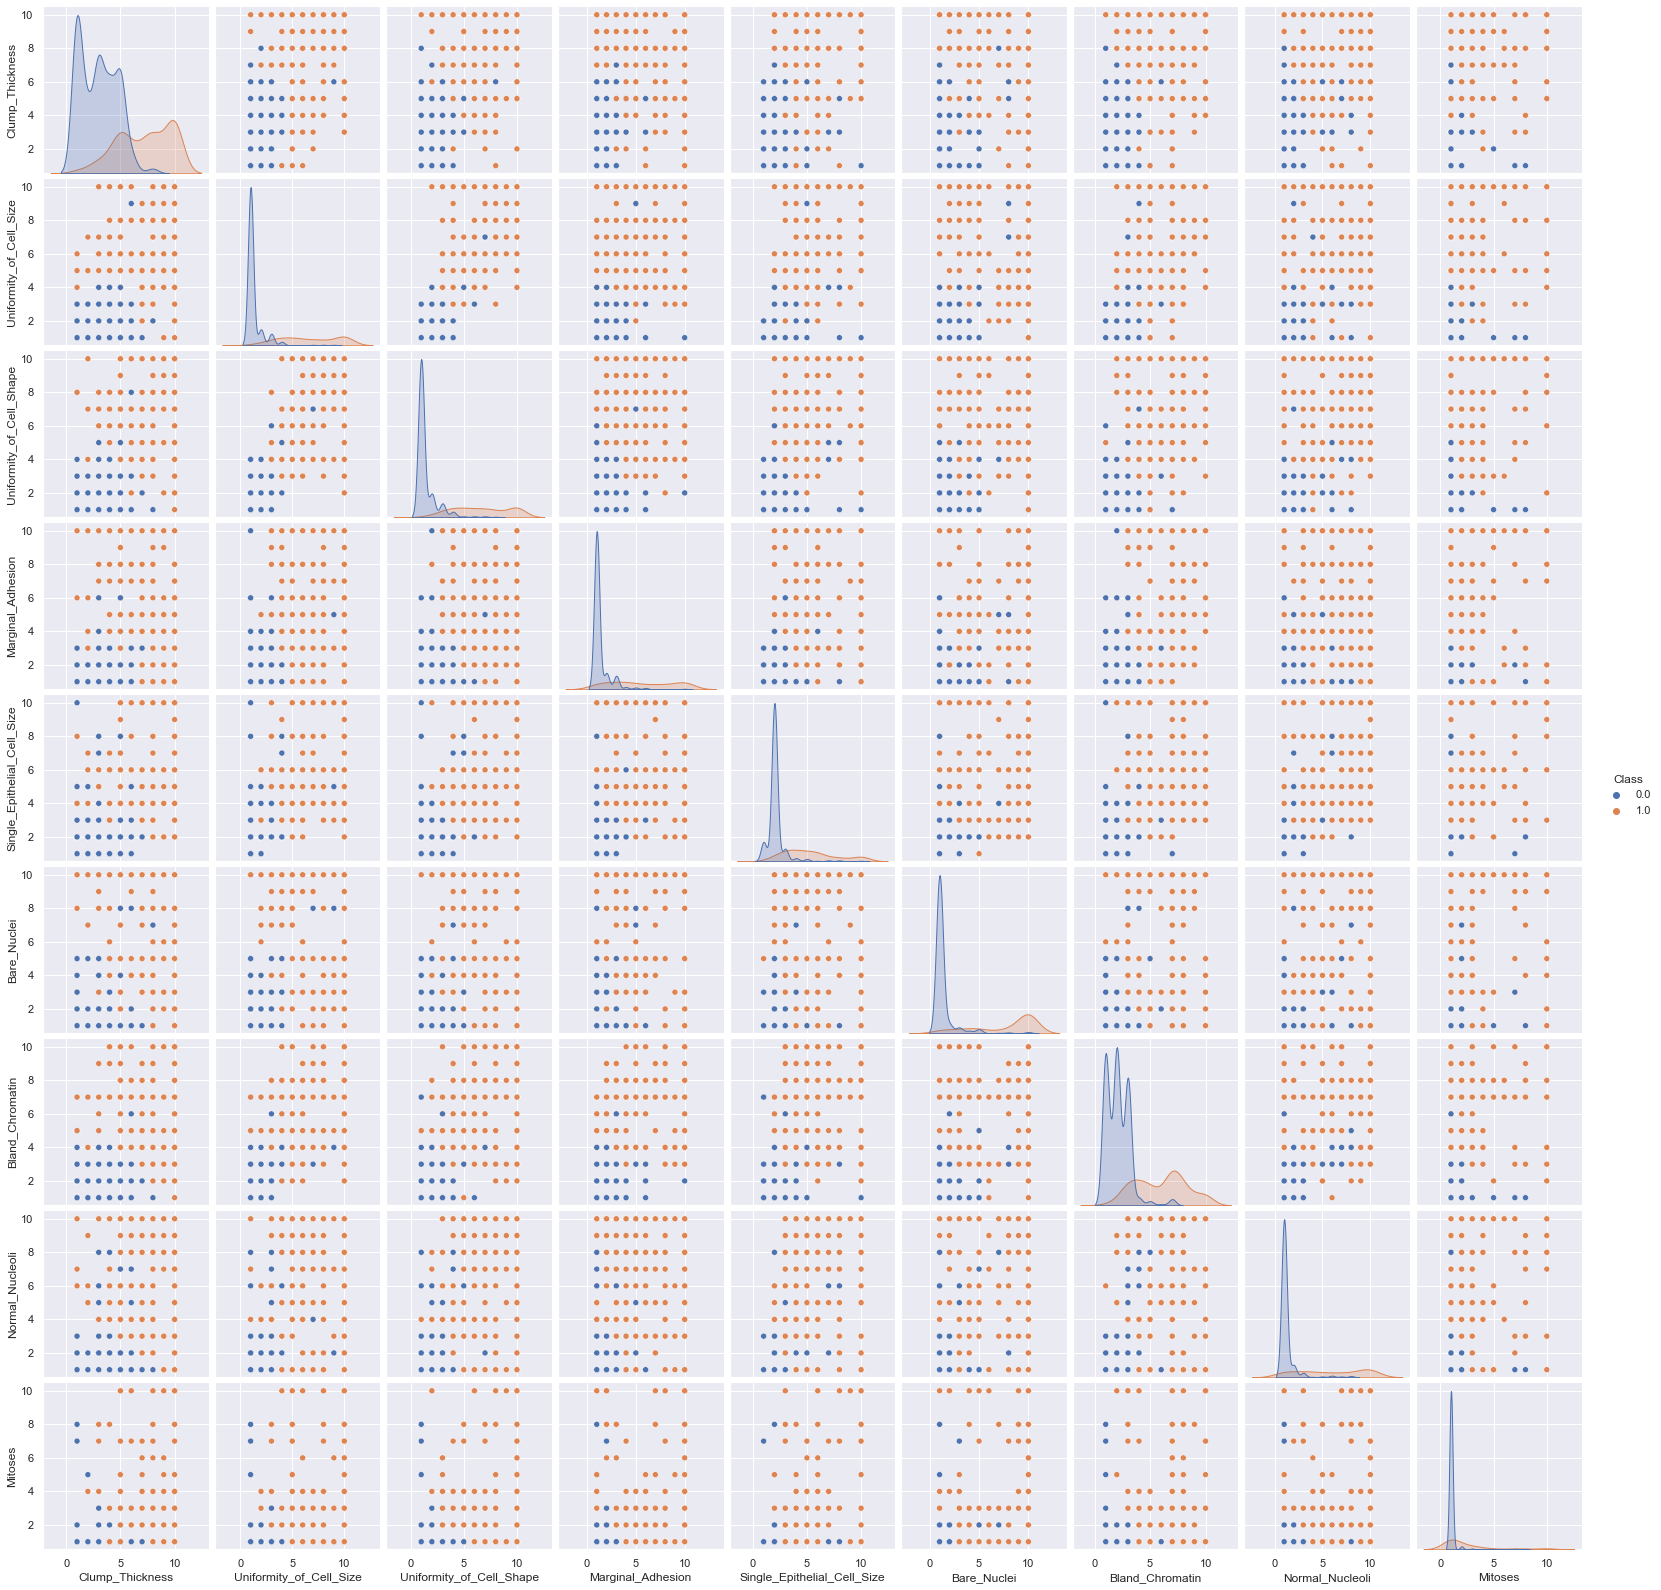

In [5]:
sns.set(rc={'figure.figsize':(25,10)})
sns.pairplot(pd_data, hue='Class', height=2.5)

This trend can also be seen by looking at the distribution of each attribute in the two classes

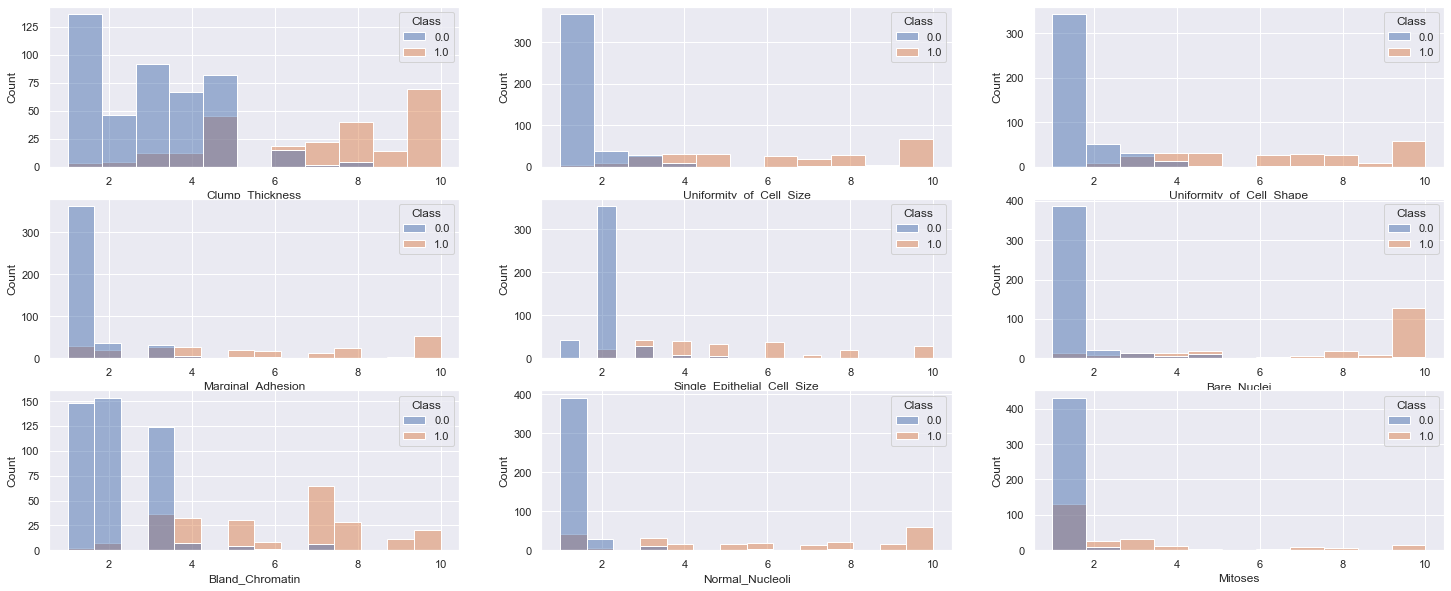

In [6]:
features = [feature for feature in pd_data.columns if feature != 'Class']
for feature, i in zip(features, range(1, 10)):
    plt.subplot(3, 3, i)
    sns.histplot(data= pd_data, x= feature, hue="Class", multiple="layer")

<AxesSubplot:>

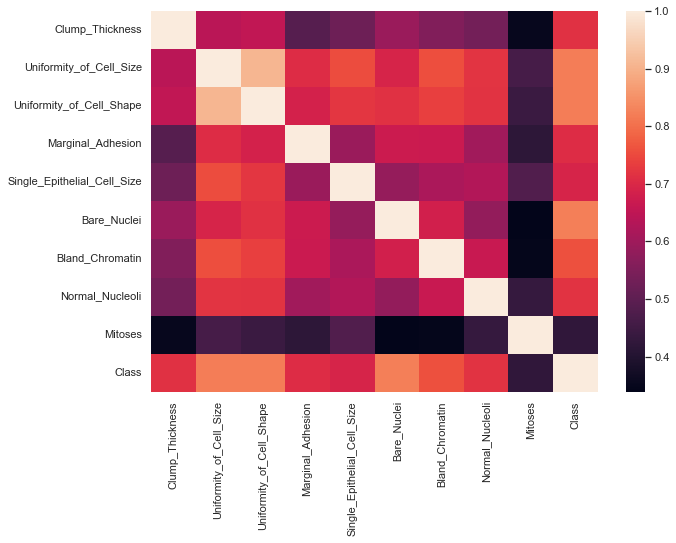

In [7]:
sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(pd_data.corr())

Last but not least we can see that Bare Nuclei, Uniformity of cell Size and Shape are highly correlated with the class, as expected given the biological relevance of these attributes in the classification of tumors.

# Evaluators: Accuracy and Sensitivity

The task of this analysis is to classify correctly a patient given its characteristics.
For this, we can use various linear classifiers coupled with meaningful metrics to rank them and eventually pick the best one for this task.

Classifiers can be divided into generative or discriminative approaches. The former wants to derive the classifier from some generative hypothesis about the way data have been generated. (ex: LDA; QDA) While the latter focus on finding the prescribed boundary able to reduce the classifier error. (ex: SVM).

To evaluate the classifiers we can use the accuracy of the classifier which measures the proportion of true positives (correctly classified malignant cases) and true negatives (correctly classified benign cases) predictions among the total number of cases examined.

In the clinical field is best to minimize the false negative cases (malignant cases wrongly classified as benign) since it would lead to catastrophic results for the patients. While a false positive result would be expensive (due to follow-up analysis) but much safer for the patient.

With this in mind, the best metric to evaluate our classifiers, to me, is the recall score (also known as sensitivity) since it measures the proportion of correctly classified all the positive samples, in our case the malignant cases.

For all the subsequent analyses I will always consider both accuracy and recall, giving more importance to recall. Since both metrics are required to get a good understanding of the performance of a classifier. (Toy example: a dumb classifier that always returns malignant as class will have the best possible recall (1) but would have low accuracy. So would be useless for this task!).

In addition to the two scores I will also use confusion matrix, to see better how the classifier performs on the test data.

In [8]:
# we can define the accuracy and also import the recall
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

from sklearn.metrics import recall_score

# Understanding different classifiers
To better understand how each classifier works I decided to use a toy example, selecting only two variables from the breast cancer dataset (Bland Chromatin and Normal Nucleoli). Using only two variables we can also plot our data and see the behavior of the classifiers.

I picked Bland Chromatin and Normal Nucleoli since classification using only these two attributes lead to a non-linearly separable problem in 2 dimension. (this will be important for later considerations on the full dataset). Also, other combinations of features would lead to the same situations, but to me this combination seemed the most interesting.

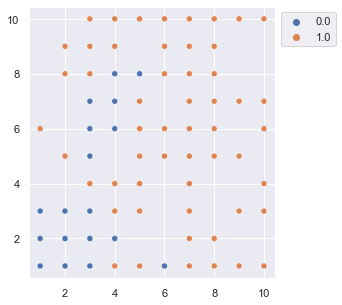

In [9]:
a = (pd.DataFrame(data = pd_data, columns = ('Bland_Chromatin', 'Normal_Nucleoli')).to_numpy(),
     pd_data['Class'].to_numpy())
datasets = [a]

figure = plt.figure(figsize=(15, 5))
for i, (X, y) in enumerate(datasets):
    ax = plt.subplot(1, 3, i+1)
    sns.scatterplot(X[:, 0], X[:, 1], hue=y, ax=ax)
    plt.legend(bbox_to_anchor=(1,1), loc = 'best')

Looking at the plot we can clearly differentiate two groups of benign cases surrounded by malignant cases. So is clearly a non-linearly separable case in 2 dimensions

## Classifiers used:
To have a better understanding of the classifiers used for this analysis here is a very quick summary of them:

• **KNN**: is a non-parametric algorithm that, given a point, finds the K nearest points from it and classifies the point with the most frequent label occurring in the neighborhood. We can use a grid search to optimize the number K nearest neighbor.

• **Perceptron**: it uses an iterative algorithm and a linear decision boundary. It stops as soon as all the training values are correctly classified. This may lead to a decision boundary very close to some training data, which is not optimal if we want a robust classifier.

• **Logistic regression**: models the posterior probability of the class (p(X)) by regressing the logistic function. It is easy to understand but is quite limited since the data must be linearly separable for optimal results (the decision boundary is linear).

• **SVM**: belongs to the non-parametric models, and is based on a simple intuition.
  If the data is linearly separable, then there will exist an infinite number of separating lines. Now the problem is to pick the best line among all the possible ones. So we can define the maximal margin hyperplane, which is the hyperplane that has the farthest minimum distance to the training observations.
  Furthermore, we can differentiate between:
    - **Hard margins**: do not allow miss-classification.
    - **Soft margins**: regulate miss-classification using a slack variable, which allows individual observations to be on the wrong side of the margin, and a cost parameter ( C ) defining the number of miss-classification allowed using a linear decision boundary.
    - **SVM using kernels**: Kernels are a way to enlarge the feature space to accommodate non-linear boundary decisions between classes since the decision boundary in the enlarged space is still linear! Those are the most flexible model of the bunch. The kernels used are: **Radial Basis Function** (rbf), **Polynomial Kernel** (poly) and **Sigmoid Kernel** (sigm).

• **LDA**: estimates the density function of predictors to approximate the Bayes classifier to model p(X). Some assumptions are required:
     - The density functions of the predictors are distributed as a multivariate Gaussian.
	 - All classes shared a common variance (and therefore covariance matrix).
note: Assuming a common variance for all the classes leverage the bias-variance trade-off to obtain better results for a small sample size. Also in this case the decision boundary is linear, but a more complex boundary can be obtained by converting features into a **polynomial** and therefore projecting them into a higher-dimensional space.

• **QDA**: Is a classifier similar to LDA but with a decision boundary quadratic since it ease the assumption of a common variance shared by the classes. This way it leverages the bias-variance trade-off, having a more flexible decision boundary.
note: QDA like LDA assumes that the density functions of the predictors are a multivariate Gaussian distribution.

In [10]:
classifiers = [
    ("KNN", KNeighborsClassifier(), {"n_neighbors": range(1, 4)}),
    ("Perceptron", Perceptron(), None),
    ("LogisticRegression", LogisticRegression(fit_intercept=True), None),
    ("LinearSVM", SVC(kernel='linear'), {"C": np.linspace(0.0001, 100, 10)}),
    ("RBFSVM", SVC(kernel='rbf'), {'C': np.linspace(0.001, 100, 5),
                                   'gamma': np.linspace(0.001, 100, 5),
                                   'coef0': np.linspace(-10, 10, 5)}),
    ("PolySVM", SVC(kernel='poly'), {"C": np.linspace(0.0001, 100, 10),
                                     "degree": range(2, 4),
                                     "coef0": np.linspace(-10, 10, 5)}),
    ("SigmoidSVM", SVC(kernel='sigmoid'), {'C': np.linspace(0.001, 100, 5),
                                           'gamma': np.linspace(0.001, 100, 5),
                                           'coef0': np.linspace(-10, 10, 5)}),
    ("LDA", LDA(), None),
    ("PolyLDA", Pipeline([('poly', PolynomialFeatures()),
                          ('lda', LDA())]), {"poly__degree": range(2, 4)}),
    ("QDA", QDA(), None)
]

/var/folders/nx/9kjdn6x158927qbzy599pcg00000gn/T/ipykernel_8394/4252027354.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cm)
/var/folders/nx/9kjdn6x158927qbzy599pcg00000gn/T/ipykernel_8394/4252027354.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cm)
/var/folders/nx/9kjdn6x158927qbzy599pcg00000gn/T/ipykernel_8394/4252027354.py:47: MatplotlibDeprecationWarning: shading='flat' when X and 

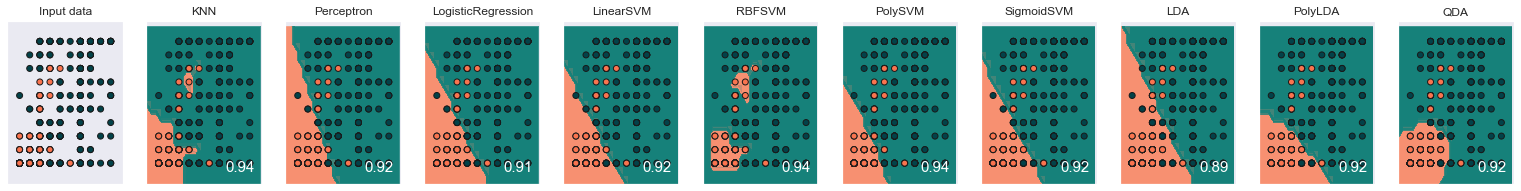

In [11]:
figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, (X, y) in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))
    X_grid= np.stack([xx.reshape(-1), yy.reshape(-1)], axis=-1)

    # just plot the dataset first
    cm = ListedColormap(['#f79071', '#16817a'])
    cm_bright = ListedColormap(['#fa744f', '#024249'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, model, grid_params in classifiers:
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if grid_params is not None:
            grid = GridSearchCV(model, grid_params, cv=5,
                                scoring='accuracy', refit=True, n_jobs=10)
            grid.fit(X, y)
            model = grid.best_estimator_
            score = grid.best_score_
        else:
            model = model.fit(X, y)
            score = np.mean(cross_val_score(model, X, y, scoring="accuracy", cv=5))
        if hasattr(model, "decision_function"):
            Z = model.decision_function(X_grid)
        else:
            Z = model.predict_proba(X_grid)[:, 1]
        Z = model.predict(X_grid)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cm)
        ax.contourf(xx, yy, Z, alpha=.8, cmap=cm)

        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

        # Fix the plot size
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # Remove ruler over the axis
        ax.set_xticks(())
        ax.set_yticks(())
        # Print the algorithm name if in the first row
        if ds_cnt == 0:
            ax.set_title(name)
        # Print the test accuracy
        ax.text(x_max - .3, y_min + .3, # coordinate where to write
                ('%.2f' % score), # what to write
                size=15, horizontalalignment='right', color="white")
        i += 1

As expected Perceptron, Logistic regression, Linear SVM and LDA split the data using a line and are not able to separate perfectly the data since the problem is non-linearly separable. While QDA, polynomial LDA, SVM using kernels and KNN achieve higher accuracy scores because they use a much more flexible decision boundary.

# Using various classifiers
We split the data in train and test keeping the unbalanced ratio of malignant vs benignant using ``` stratify = y ``` . This way we are sure to have a train set that is representative of the test set.

As stated before for each classifier we will use the recall score, the accuracy score and the test confusion matrix to evaluate how the performance of the classifier with respect to the task.

In [12]:
split_seed = 42
split_test_size = 0.3

y = pd_data['Class'].to_numpy().astype(np.float32)
X = pd_data[features]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size,
                                                    random_state=split_seed,
                                                    stratify = y)

X = X_train.to_numpy()
X_t = X_test.to_numpy()

# Logistic Regression

Train accuracy: 0.9643605870020965
Test accuracy: 0.9707317073170731
Train recall: 0.9461077844311377
Test recall: 0.9444444444444444


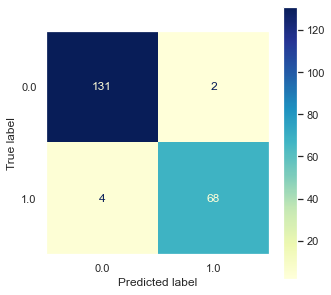

In [13]:
model = LogisticRegression(solver='newton-cg', penalty='none') # 2- hyperparams
model.fit(X_train, y_train)                               # 3- model fitting
y_predict = model.predict(X_train)                        # 4- model testing

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

sns.set(rc={'figure.figsize':(5,5)})
plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

Interestingly using logistic regression lead to decent results for the test set with a recall of ```94%``` and an accuracy of ```97%```. This will be the baseline to compare the other classifiers.

## Feature selection
Just out of curiosity I wanted to test if using a feature selection method is possible to obtain a better or equally good classifier model with fewer features.
So I decide to perform Lasso and pick the best 3 features, so the last 3 that are shrunk to zero.

## Lasso

Text(0, 0.5, 'beta')

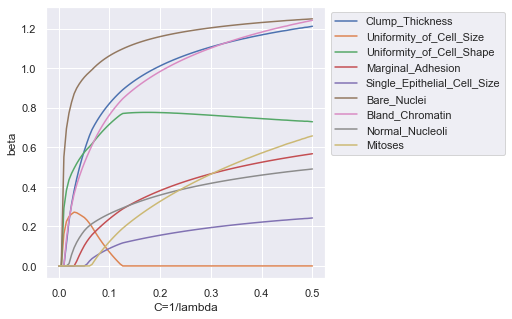

In [14]:
C_vals = np.linspace(1e-4, 0.5, 100)
betas = []


X_std = preprocessing.scale(X_train)
first_to_zero = []

for C in C_vals:
    model = LogisticRegression(solver='saga', penalty='l1', C=C, max_iter = 10000)
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
    first_to_zero.append(np.where( beta != 0)[0])               # <-------------- needed for the function get Lasso
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]

array_list = [array for array in first_to_zero if 0 not in array.shape]     # <---- needed for get_lasso

for beta, name in zip(betas, features):
    plt.plot(C_vals, beta, label=name)
plt.legend(bbox_to_anchor=(1,1), loc = 'best')
plt.xlabel("C=1/lambda")
plt.ylabel("beta")

Uniformity of cell size has a peculiar behaviour. It seems that when the uniformity of cell shape starts reaches its pick of importance (the highest coefficient value), then uniformity of cell size start to assume importance. Or is also possible that uniformity of cell size starts to gain relevance once most of the other features are shrunken, and so they no longer mask the relevance of the feature.

In [15]:
def get_Lasso(num_features = 5):    # function also used in the first HW.
    len_old_list = 0
    for i in range(len(array_list)):    #defined in the previous chunck
        new_list = []
        for idx in range(array_list[i].shape[0]):
            new_list.append(features[array_list[i][idx]])
        if len(new_list) == len_old_list:
            pass
        elif (len(new_list) == num_features) or (len(new_list) < num_features):
            print(new_list)
            break
        else:
            pass
        len_old_list = len(new_list)

In [16]:
get_Lasso(3)

['Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Bare_Nuclei']


As expected the 3 most correlated features to the class variable are also the most meaningful (with **Bare_Nuclei** being the most important)

# Logistic regression after feature selection

In [17]:
X_lasso = ['Bare_Nuclei', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape']
X = pd_data[X_lasso]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = split_test_size,
                                                    random_state = split_seed,
                                                    stratify = y)

X = X_train.to_numpy()
X_t = X_test.to_numpy()

Train accuracy: 0.960167714884696
Test accuracy: 0.9512195121951219
Train recall: 0.9281437125748503
Test recall: 0.9027777777777778


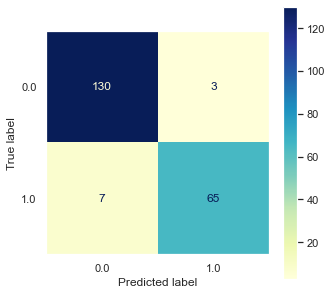

In [18]:
model = LogisticRegression(solver='newton-cg', penalty='none') # 2- hyperparams
model.fit(X_train, y_train)                               # 3- model fitting
y_predict = model.predict(X_train)                        # 4- model testing

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

Surprisingly the accuracy of both test and train is lower! Meaning that the full model is better than a model with only the 3 most meaningful features.
Also looking at the confusion matrix we can easily see that Logistic regression with all the features performs way better having much less False negative! (also notable comparing the recall score, which loses almost 0.4 points.


## LDA

Train accuracy: 0.9622641509433962
Test accuracy: 0.9512195121951219
Train recall: 0.9281437125748503
Test recall: 0.8888888888888888


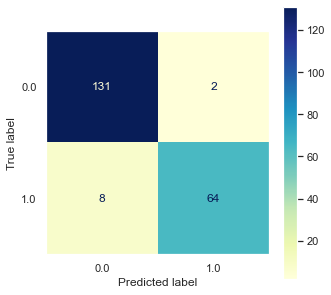

In [19]:
X = pd_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = split_test_size,
                                                    random_state = split_seed,
                                                    stratify = y)
X = X_train.to_numpy()

model = LDA()
model = model.fit(X_train, y_train)
print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))


cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

Given the strict assumption of LDA we expected a poor classifier. The test recall (```~0.89```)is quite low, while the test accuracy (```0.95```) is decent.

# LDA polynomial
Using a more flexible decision boundary employing polynomial LDA might benefit the recall score.

## Hyperparameter tuning
To select the best parameters we can perform a grid search using first the accuracy score and than the recall score as a metrix to tune hyperparameters.

In [20]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y,
                                                                      test_size=val_size,
                                                                      random_state=0,
                                                                      stratify= y)
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val)

        return model, score
    return evaluator

## Grid search: accuracy

In [21]:
model = LDA(store_covariance=True) # to retrieve later the Learned covariance using model.covariance_
model = model.fit(X_train, y_train)

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 5)}

cv = GridSearchCV(model, params, refit=True, cv=10,
                  scoring=make_scorer(accuracy))
cv.fit(X_train, y_train)

cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003571,0.000694,0.000822,0.000179,1,{'poly__degree': 1},0.979167,0.916667,0.9375,0.937500,0.979167,0.979167,1.000000,0.957447,0.957447,0.978723,0.962278,0.024298,2
1,0.007759,0.002257,0.000817,0.000088,2,{'poly__degree': 2},0.979167,0.916667,0.9375,0.958333,1.000000,0.979167,1.000000,0.957447,0.957447,0.978723,0.966445,0.025039,1
2,0.041274,0.004064,0.001064,0.000135,3,{'poly__degree': 3},0.770833,0.770833,0.8750,0.770833,0.875000,0.791667,0.833333,0.936170,0.829787,0.914894,0.836835,0.058348,4
3,0.266560,0.024349,0.001363,0.000202,4,{'poly__degree': 4},0.791667,0.708333,0.8750,0.812500,0.854167,0.833333,0.895833,0.978723,0.851064,0.872340,0.847296,0.067005,3


  (best 2) CV accuracy: 0.9664450354609929
  (best 2) Test accuracy: 0.9658536585365853


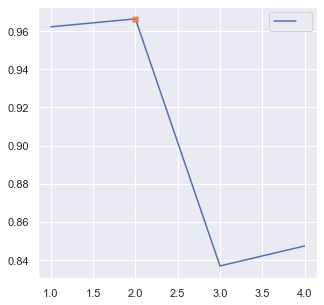

In [22]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix
    results = pd.DataFrame(cv.cv_results_)
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    # Plot it as a cross
    plt.plot(results[params][best_idx],
             results['mean_test_score'][best_idx], marker='X')

    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))

show_results(cv, X_test, 'param_poly__degree')

Looking at the graph we can see that the best grade is 2.

## Grid search: recall

In [23]:
model = LDA(store_covariance=True) # to retrieve later the Learned covariance using model.covariance_
model = model.fit(X_train, y_train)

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 5)}

cv = GridSearchCV(model, params, refit=True, cv=10,
                  scoring=make_scorer(recall_score))
cv.fit(X_train, y_train)

cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003137,0.000452,0.001345,0.000111,1,{'poly__degree': 1},0.941176,0.882353,0.823529,0.941176,0.941176,1.000000,1.000000,0.8750,0.8750,1.0000,0.927941,0.058897,2
1,0.007152,0.000809,0.001494,0.000158,2,{'poly__degree': 2},0.941176,0.882353,0.823529,1.000000,1.000000,1.000000,1.000000,0.8750,0.9375,1.0000,0.945956,0.062263,1
2,0.035637,0.003668,0.001871,0.000350,3,{'poly__degree': 3},0.529412,0.529412,0.705882,0.411765,0.705882,0.411765,0.588235,0.8125,0.6250,0.8125,0.613235,0.138772,3
3,0.262864,0.018447,0.001833,0.000172,4,{'poly__degree': 4},0.470588,0.294118,0.647059,0.529412,0.647059,0.588235,0.705882,0.9375,0.6875,0.6250,0.613235,0.158590,3


  (best 2) CV recall score: 0.9459558823529411
  (best 2) Test recall score: 0.9444444444444444


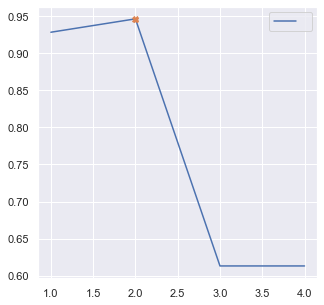

In [24]:
def show_results_recall(cv, X_test, params, prefix=''):
    prefix = ' '+prefix
    results = pd.DataFrame(cv.cv_results_)
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    # Plot it as a cross
    plt.plot(results[params][best_idx],
             results['mean_test_score'][best_idx], marker='X')

    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV recall score:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test recall score:", recall_score(y_test, cv.best_estimator_.predict(X_test)))

show_results_recall(cv, X_test, 'param_poly__degree')

Also using the recall score the best degree is 2, so we can fit a two degree polynomial LDA.

Train accuracy: 0.9811320754716981
Test accuracy: 0.9658536585365853
Train recall: 0.9820359281437125
Test recall: 0.9444444444444444


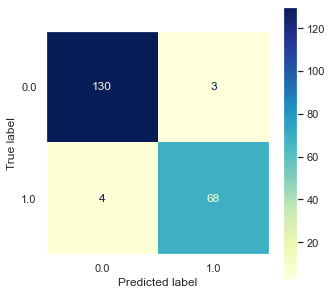

In [25]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree = 2)),   # change teh degree to have a more complex shape of the division line
    ('lda', LDA(store_covariance=True))])
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

Both the test recall and accuracy sensibly improved!


# QDA
Easing the assumption of a shared common variance between the classes may benefit the model.

Train accuracy: 0.9580712788259959
Test accuracy: 0.9414634146341463
Train recall: 0.9820359281437125
Test recall: 0.9583333333333334


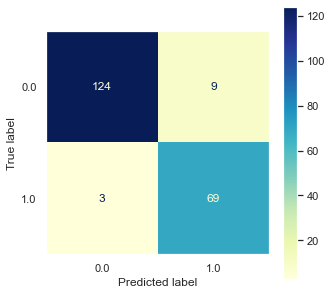

In [26]:
model = QDA(store_covariance= True)
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

The test recall score is exceptional, without loosing too accuracy. Also looking at the confusion matrix we can see that only 3 cases were classified as False negative!

# KNN with Hyperparameter tuning

### Normalizing is meaningful?
Since all the features span from 1 up to 10 normalizing or standardizing should not be meaningful since all the features share already a common scale. As for
feature selection I performed hyperparameter tuning on normalized and standardized data to compared them with the Unnormalized one just out of curiosity.
As for polynomial LDA I performed two different grid search, first using the accuracy score and then the recall score.

#### Accuracy grid search

 Unnormalized (best 3) CV accuracy: 0.9707003546099291
 Unnormalized (best 3) Test accuracy: 0.9707317073170731
 StandardScaler (best 3) CV accuracy: 0.968572695035461
 StandardScaler (best 3) Test accuracy: 0.9658536585365853
 MinMaxScaler (best 5) CV accuracy: 0.9727836879432624
 MinMaxScaler (best 5) Test accuracy: 0.9707317073170731


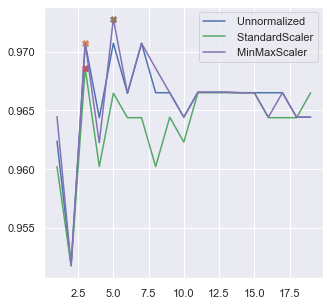

In [27]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 20)}
folds=10
scorer = make_scorer(accuracy)

# Unnormalized
cv = GridSearchCV(model, params, cv = folds, scoring = scorer)
cv.fit(X_train, y_train)

params = {'knn__n_neighbors': range(1, 20)}

# StandardScaler
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(accuracy))
cv_std.fit(X_train, y_train)

# MinMaxScaler
model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(accuracy))
cv_minmax.fit(X_train, y_train)

# Plot the cv lines
show_results(cv, X_test, "param_n_neighbors", prefix="Unnormalized")
show_results(cv_std, X_test, 'param_knn__n_neighbors', "StandardScaler")
show_results(cv_minmax, X_test, 'param_knn__n_neighbors', "MinMaxScaler")

#### Recall grid search

 Unnormalized (best 3) CV recall score: 0.9580882352941178
 Unnormalized (best 3) Test recall score: 0.9444444444444444
 StandardScaler (best 3) CV recall score: 0.968572695035461
 StandardScaler (best 3) Test recall score: 0.9305555555555556
 MinMaxScaler (best 5) CV recall score: 0.9727836879432624
 MinMaxScaler (best 5) Test recall score: 0.9305555555555556


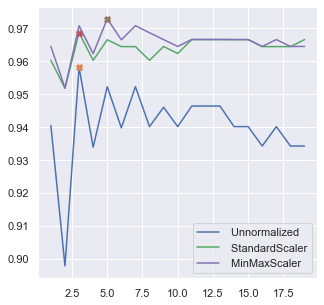

In [28]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 20)}
folds = 10
scorer = make_scorer(recall_score)

# Unnormalized
cv = GridSearchCV(model, params, cv = folds, scoring = scorer)
cv.fit(X_train, y_train)

params = {'knn__n_neighbors': range(1, 20)}
# StandardScaler
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(accuracy))
cv_std.fit(X_train, y_train)

# MinMaxScaler
model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(accuracy))
cv_minmax.fit(X_train, y_train)

# Plot the cv lines
show_results_recall(cv, X_test, "param_n_neighbors", prefix="Unnormalized")
show_results_recall(cv_std, X_test, 'param_knn__n_neighbors', "StandardScaler")
show_results_recall(cv_minmax, X_test, 'param_knn__n_neighbors', "MinMaxScaler")

Un-normalized:
Train accuracy: 0.9748427672955975
Test accuracy: 0.9707317073170731
Train recall: 0.9700598802395209
Test recall: 0.9444444444444444


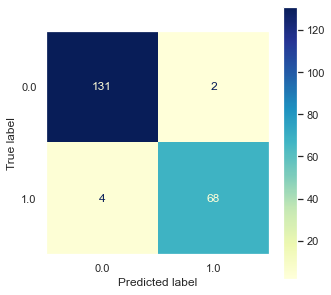

In [29]:
# Un-normalized and Standardized
model = KNeighborsClassifier(n_neighbors= 3)
model.fit(X_train, y_train)

print('Un-normalized:')
print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

MinMaxScaler:
Train accuracy: 0.9769392033542977
Test accuracy: 0.975609756097561
Train recall: 0.9700598802395209
Test recall: 0.9444444444444444


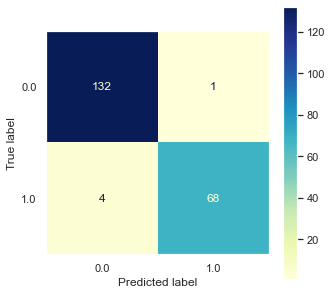

In [30]:
# MinMaxScaler
model = KNeighborsClassifier(n_neighbors= 5)
model.fit(X_train, y_train)

print('MinMaxScaler:')
print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print('Train recall:', recall_score(y_train,  model.predict(X_train)))
print('Test recall:', recall_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

Comparing the results of the two KNN models with 3 and 5 K neighbours respectively, lead to no clear difference looking only at the scores. Only using the confusion matrix we can see that 5 neighbours KNN lead to 1 False positive instead of 2. This is a minor improvement, but still an improvement. Thus confirming that normalization and standardization are meaningless for this task.

# SVM
Up to this point I assumed that data might be linearly separable in 9 dimension, but we should try to prove it. This is relevant for our task since could explain why some classifiers outperforms others (like in the Toy example).

Given that we are using 9 features it is impossible to plot our data to see whether they are linearly separable. So we should relay on different approaches.
Probably the most simple one is to use linear SVM classifier with C = infinity, so that it does not allow for miss-classification! This way, if the classifier does not find a result I can be certain that the data are not linearly separable in K dimensions.

In [31]:
# model = SVC(kernel= 'linear', C= np.inf)
# model.fit(x_train, y_train)

Interestingly the classifier does find a linear decision boundary able to classify correctly all the patients, proving once for all that the data can are not linearly separated.

# SVM linear
Since the data are not linearly separable we must use soft margin SVM. In this way we can account for miss classification using a penalty. To select the best penalty we can perform once again a grid search.

note: All the grid searches for SVM classifiers (soft margin and kernels) were performed using both accuracy and recall as metrix. Since there is little to no difference in the parameters selected by both metrix, I decided to include only the grid searches performed using accuracy.

SVC(C=0.001, kernel='linear')
cv score (accuracy): 0.9623464912280701
cv score (recall): 0.9522058823529413
Accuracy scores:
train score: 0.9685534591194969
test score: 0.975609756097561
Recall scores:
train score: 0.9520958083832335
test score: 0.9583333333333334



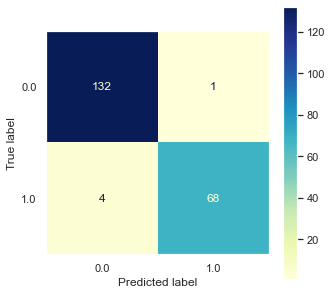

In [32]:
param_grid = {'C': np.linspace(0.001, 100, 5)}
svm_ln = GridSearchCV(SVC(kernel='linear'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
svm_ln.fit(X_train, y_train)

cv_score = svm_ln.best_score_
svm_ln= svm_ln.best_estimator_
print(svm_ln)

scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = make_scorer(recall_score))
cv_score_rec = scores.mean()


#accuracy
train_acc = accuracy_score(y_train, svm_ln.predict(X_train))
test_acc = accuracy_score(y_test, svm_ln.predict(X_test))
print("cv score (accuracy): {}".format(cv_score))
print("cv score (recall): {}".format(cv_score_rec))

print('Accuracy scores:')
print("train score: {}".format(train_acc))
print("test score: {}".format(test_acc))

train_rec = recall_score(y_train, svm_ln.predict(X_train))
test_rec = recall_score(y_test, svm_ln.predict(X_test))
print('Recall scores:')
print("train score: {}".format(train_rec))
print("test score: {}\n".format(test_rec))

cm = confusion_matrix(y_test, model.predict(X_test))
plot_confusion_matrix(model, X_test, y_test, include_values= True, cmap = 'YlGnBu')
plt.grid(False)

The results show both a good recall and high accuracy! This can also be noticed by looking at the confusion matrix.

# Kernel trick
Using a kernel trick may lead to better result given that the data is not linearly separable.
I used as kernels: polynomial, rbf and sigmoid.

In [33]:
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
svm_poly.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
rbf_poly.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid,
                         cv=5, scoring='accuracy', refit=True)
sigm_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='accuracy')

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score (accuracy): 0.9665131578947369
cv score (recall): 0.9522058823529413
Accuracy scores:
train score: 0.9727463312368972
test score: 0.9707317073170731
Recall scores:
train score: 0.9640718562874252
test score: 0.9444444444444444

SVC(C=75.00025, gamma=0.001)
cv score (accuracy): 0.9665131578947369
cv score (recall): 0.9522058823529413
Accuracy scores:
train score: 0.9769392033542977
test score: 0.975609756097561
Recall scores:
train score: 0.9760479041916168
test score: 0.9722222222222222

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score (accuracy): 0.9623245614035089
cv score (recall): 0.9522058823529413
Accuracy scores:
train score: 0.9706498951781971
test score: 0.9707317073170731
Recall scores:
train score: 0.9580838323353293
test score: 0.9444444444444444



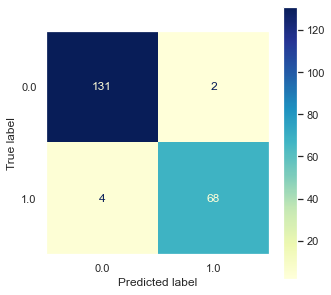

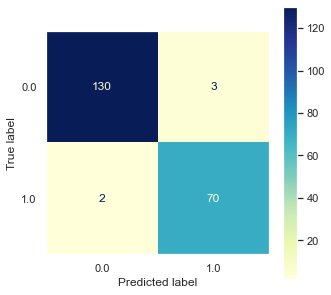

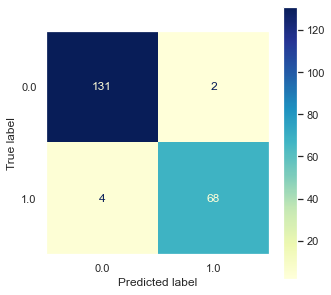

In [34]:
for m in [svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)

    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = make_scorer(recall_score))
    cv_score_rec = scores.mean()

    #accuracy
    train_acc = accuracy_score(y_train, m.predict(X_train))
    test_acc = accuracy_score(y_test, m.predict(X_test))
    print("cv score (accuracy): {}".format(cv_score))
    print("cv score (recall): {}".format(cv_score_rec))

    print('Accuracy scores:')
    print("train score: {}".format(train_acc))
    print("test score: {}".format(test_acc))

    #recall
    train_rec = recall_score(y_train, m.predict(X_train))
    test_rec = recall_score(y_test, m.predict(X_test))
    print('Recall scores:')
    print("train score: {}".format(train_rec))
    print("test score: {}\n".format(test_rec))

    cm = confusion_matrix(y_test, m.predict(X_test))
    plot_confusion_matrix(m, X_test, y_test, include_values= True, cmap = 'YlGnBu')
    plt.grid(False)

All the classifiers performed very well, always achieving high recall and accuracy scores using cross validation.
Out of all SVM with rbf kernel seems the best one and is confirmed also by the confusion matrix.

# Receiver Operator Curve (ROC)
Another way to evaluate the goodness of a classifier is to use a ROC. The ROC is used to evaluate how sensitivity changes with respect to the threshold value set for the posterior probability (which is usually 0.5 by default). Given the medical contex is best to have more False positive than False negative so, using the ROC, we could adjust the threshold value to favour the prediction of the malignant class.

We can also measure the Area Under the Curve to estimate the performance of a classifier, the larger the AUC the better the model.

In [35]:
def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])

    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

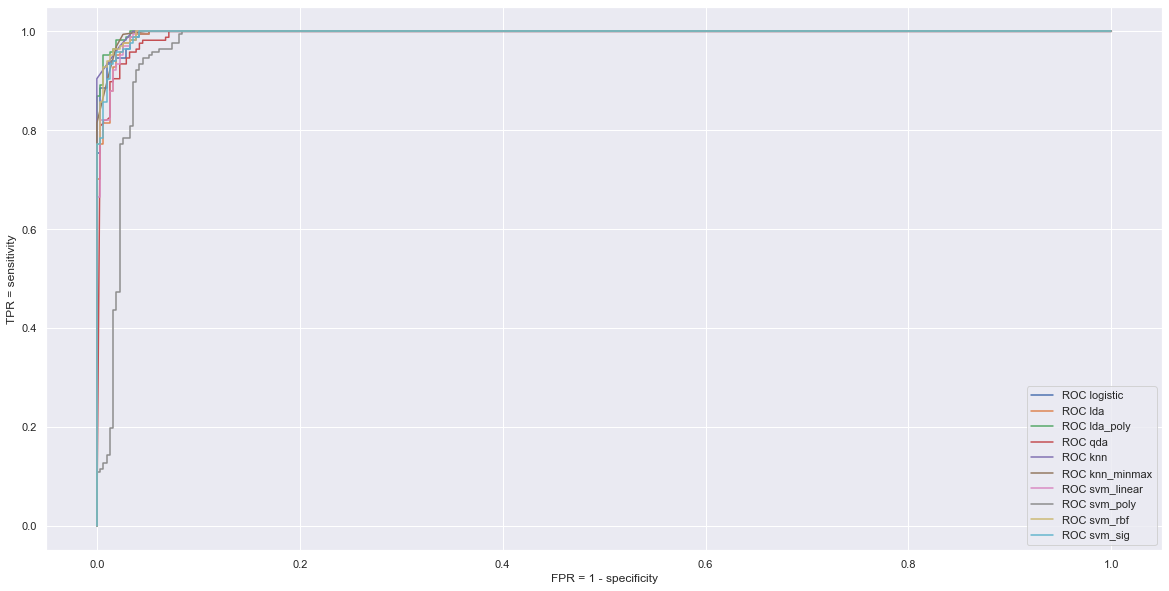

In [36]:
sns.set(rc={'figure.figsize':(20,10)})
logistic = LogisticRegression(solver='newton-cg', penalty='none')

lda = LDA()
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA(store_covariance=True))])
qda = QDA()
knn = KNeighborsClassifier(n_neighbors=3)
knn_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))])
knn_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))])


svc = SVC(kernel='linear', C=0.001, coef0=-10.0, probability=True)
svm_lin = svc.fit(X_train, y_train)

svc = SVC(kernel='poly', C=0.001, coef0=-10.0, probability=True)
svm_poly = svc.fit(X_train, y_train)

svc = SVC(kernel = 'rbf', C=50.000499999999995, gamma=0.001, probability=True)
svm_rbf = svc.fit(X_train, y_train)

svc = SVC(kernel = 'sigmoid', C=25.00075, gamma=0.001, probability=True)
svm_sig = svc.fit(X_train, y_train)

models = OrderedDict([('logistic  ', logistic), ('lda       ', lda),        ('lda_poly  ', lda_poly), ('qda       ', qda),
                      ('knn       ', knn),      ('knn_minmax', knn_minmax), ('svm_linear', svm_lin),  ('svm_poly  ', svm_poly), ('svm_rbf   ', svm_rbf),
                      ('svm_sig   ', svm_sig), ])


for name, model in models.items():
    model.fit(X_train, y_train)
    plot_roc(model.predict_proba, X_train, y_train, name)

From the plot of the ROC for all the model used we can not differentiate a clearly the best model. Almost all the model have a good AUC so we should look closer to cross validation and test scores.


# Selecting the best model

           CV score accuracy           CV score recall        Accuracy test score        Recall test score
logistic        0.9623,                   0.9463,                   0.9707,                   0.9444
lda             0.9623,                   0.9279,                   0.9512,                   0.8889
lda_poly        0.9664,                   0.9460,                   0.9659,                   0.9444
qda             0.9560,                   0.9882,                   0.9415,                   0.9583
knn             0.9707,                   0.9581,                   0.9707,                   0.9444
knn_minmax      0.9728,                   0.9581,                   0.9707,                   0.9306
svm_linear      0.9623,                   0.9342,                   0.9756,                   0.9583
svm_poly        0.9498,                   0.9408,                   0.9659,                   0.9444
svm_sigm        0.9665,                   0.9581,                   0.9707,          

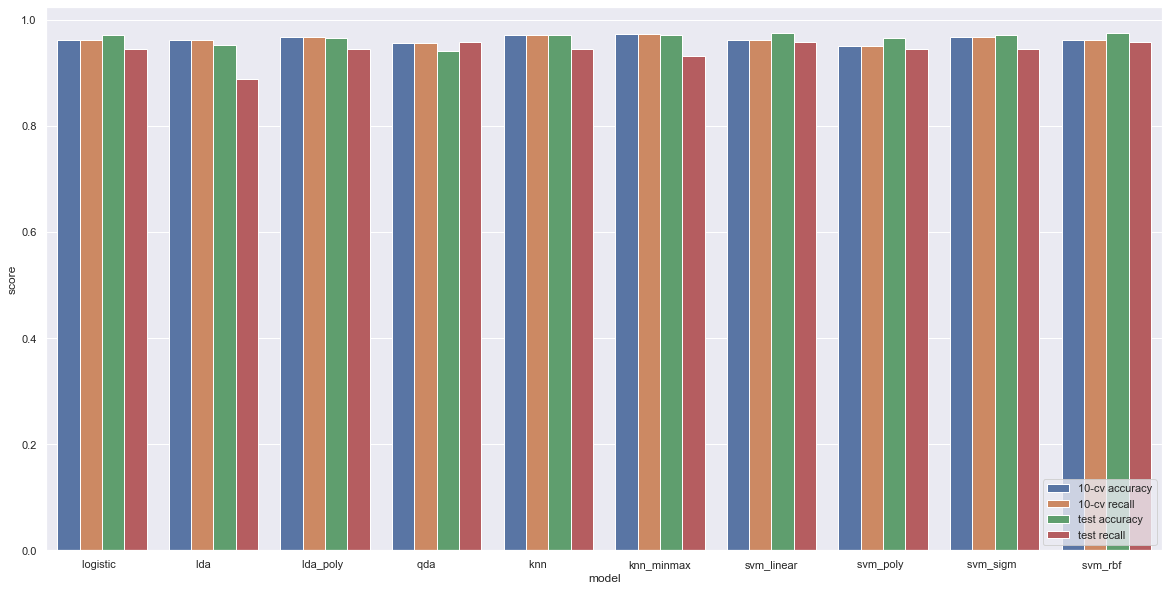

In [37]:
models = OrderedDict([('logistic  ', logistic), ('lda       ', lda),        ('lda_poly  ', lda_poly), ('qda       ', qda),
                      ('knn       ', knn),      ('knn_minmax', knn_minmax),  ('svm_linear', svm_ln),('svm_poly  ', svm_poly),('svm_sigm  ', sigm_poly), ('svm_rbf   ', svm_rbf)])

cv_scores, cv_scores_rec, test_scores_accuracy, test_scores_recall = [], [], [], []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = make_scorer(accuracy))
    cv_score = scores.mean()
    cv_scores.append(cv_score)

    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = make_scorer(recall_score))
    cv_score_rec = scores.mean()
    cv_scores_rec.append(cv_score)

    model.fit(X_train, y_train)
    test_score_acc = accuracy(y_test, model.predict(X_test))
    test_scores_accuracy.append(test_score_acc)

    test_score_rec = recall_score(y_test, model.predict(X_test))
    test_scores_recall.append(test_score_rec)
    if name == 'logistic  ':
            print('           CV score accuracy           CV score recall        Accuracy test score        Recall test score')
            print("{}      {:.4f},                   {:.4f},                   {:.4f},                   {:.4f}".format(name, cv_score, cv_score_rec, test_score_acc, test_score_rec))
    else:
        print("{}      {:.4f},                   {:.4f},                   {:.4f},                   {:.4f}".format(name, cv_score, cv_score_rec, test_score_acc, test_score_rec))



data = pd.DataFrame()
data['model'] = list(models.keys()) * 4
data['metric'] = ['10-cv accuracy'] * len(cv_scores) + ['10-cv recall'] * len(cv_scores_rec) + ['test accuracy'] * len(test_scores_accuracy) + ['test recall'] *len(test_scores_recall)
data['score'] = cv_scores + cv_scores_rec + test_scores_accuracy + test_scores_recall

sns.barplot(x='model', y='score', data=data, hue='metric')
plt.legend(loc='lower right')

Looking at the final results we can see that classifiers that assume a linear decision boundary perform surprisingly well even though the boundary is  non-linearly separable. Furthermore, the best recall score (always looking at the cross validation scores since they are the most robust scores) is achieved by QDA (```0.98```) and has also a decent accuracy (```0.95```). While the highest accuracy is achieved by KNN (```0.97```) with a much lower recall score (```0.95```). Looking at the SVMs they have very high scores if coupled with sigmoid and rbf kernels.

If I should choose a model for this task that would be QDA. As stated before having such a high recall score, while achieving a decent accuracy score enable us to classify correctly most of the cases, in the meantime avoiding dangerous miss classification of malignant cases.

# Conclusions

Predicting the class of the patients given its characteristic is a complex task. Having a good understanding of the field always give an edge on the problem and in this case suggested me to choose the recall as main metrics to evaluate the classifiers. Furthermore, selecting only the most relevant features using feature selection methods resulted in a poor classifier since, in this task, is preferable to achieve a robust way of classifying patients than to do inference on the data. QDA revealed to be the best fitted model for the task according to the recall score since it retains also a high accuracy score.

Moreover, for some classifiers (like: LDA) assumption are not met and for others (like QDA) assumption should be verified (we should verify if our data follow a normal distribution in the feature space!). Assumption are key aspect for the selection of the model, but we should always take into consideration the results given by those models, since good results may indicate that assumptions may be moderately respected.